# Time Series Forecasting of BTC price with exogenous features

In this notebook I will be using exogenous features on top of the time series values to predict the BTC price. BTC price data had been obtained from this [dataset](https://www.kaggle.com/datasets/varpit94/bitcoin-data-updated-till-26jun2021) and tweets have been obtained from here.
Following preprocessing steps have been done on the Tweets data set.


1.   Remove null values
2.   Remove non English tweets
3.   Extract date and time of the tweets
4.   Drop tweets that have been publshed after 8:00 PM
5.   Clean the text part of the tweets
6.   Use sentiment analysis libraries (Huggin Face, Flair, TextBlob) to get the sentiment value of each tweet
7.   Obtain the average sentiment of tweets for each day.
8.   Join with the BTC price data set

Here we are loading the BTC price and the tweet sentiment value data set.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
pd.__version__


'1.4.3'

In [2]:
from sklearn.metrics import mean_squared_error
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))

# Load data 



In [8]:
file_path = 'Data/tweets_sentiment_btc_usd_final_full.csv'
btc_df = pd.read_csv(file_path)
btc_df.drop('Unnamed: 0', axis=1,inplace=True)
btc_df.rename(columns = {'text':'num_tweets'}, inplace = True)
btc_df.info()
btc_df.index = pd.to_datetime(btc_df['Date'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1894 entries, 0 to 1893
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             1894 non-null   object 
 1   Open             1894 non-null   float64
 2   High             1894 non-null   float64
 3   Low              1894 non-null   float64
 4   Close            1894 non-null   float64
 5   Adj Close        1894 non-null   float64
 6   Volume           1894 non-null   int64  
 7   num_tweets       1894 non-null   int64  
 8   likes            1894 non-null   float64
 9   retweets         1894 non-null   float64
 10  replies          1894 non-null   float64
 11  tb_polarity      1894 non-null   float64
 12  tb_subjectivity  1894 non-null   float64
 13  vd_sentiment     1894 non-null   float64
dtypes: float64(11), int64(2), object(1)
memory usage: 207.3+ KB


In [9]:
btc_df.sample(10)

,Date,Open,High,Low,Close,Adj Close,Volume,num_tweets,likes,retweets,replies,tb_polarity,tb_subjectivity,vd_sentiment
Date,,,,,,,,,,,,,,
2015-04-11,2015-04-11,236.016006,239.537003,234.175003,236.552002,236.552002,16365200,911,0.196487,0.196487,0.003293,0.010625,0.188332,0.040123
2016-08-27,2016-08-27,579.452026,579.844971,568.630005,569.947021,569.947021,59698300,127,0.204724,0.204724,0.000000,0.044348,0.151335,0.010613
2019-01-27,2019-01-27,3604.687256,3612.671387,3567.245850,3583.965820,3583.965820,5570752966,18587,0.675580,0.675580,0.344111,0.104668,0.280521,0.142638
2017-03-13,2017-03-13,1221.780029,1237.369995,1217.030029,1231.920044,1231.920044,380276992,186,0.661290,0.661290,0.037634,0.044020,0.139118,0.002361
2018-05-23,2018-05-23,8037.080078,8054.660156,7507.879883,7557.819824,7557.819824,6491120128,702,13.437322,13.437322,2.507123,0.023608,0.239505,0.060392
2017-12-15,2017-12-15,16601.300781,18154.099609,16601.300781,17706.900391,17706.900391,14309999616,692,39.881503,39.881503,2.809249,0.036861,0.202554,0.046991
2016-11-29,2016-11-29,736.328979,737.471008,734.559021,735.604004,735.604004,68511104,231,0.181818,0.181818,0.000000,0.050963,0.185103,0.086940
2018-04-25,2018-04-25,9701.030273,9745.320313,8799.839844,8845.740234,8845.740234,11083100160,548,4.114964,4.114964,8.295620,0.038266,0.206546,0.061197
2019-05-22,2019-05-22,7956.291992,7997.612305,7615.987305,7680.066406,7680.066406,24719473175,52173,0.805877,0.805877,0.269986,0.106680,0.301650,0.139386


Lets remove the unwanted columns and add the lagged values to the dataset. 


In [12]:

btc_df['lag_num_tweets'] = btc_df['num_tweets'].shift(1)
btc_df['lag_tb_subjectivity'] = btc_df['tb_subjectivity'].shift(1)
btc_df['lag_tb_polarity'] = btc_df['tb_polarity'].shift(1)
btc_df['lag_vd_sentiment'] = btc_df['vd_sentiment'].shift(1)
btc_df['lag_likes'] = btc_df['likes'].shift(1)
btc_df['lag_replies'] = btc_df['replies'].shift(1)
btc_df['lag_retweets'] = btc_df['retweets'].shift(1)

In [13]:
btc_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,num_tweets,likes,retweets,...,tb_polarity,tb_subjectivity,vd_sentiment,lag_num_tweets,lag_tb_subjectivity,lag_tb_polarity,lag_vd_sentiment,lag_likes,lag_replies,lag_retweets
Date,,,,,,,,,,,,,,,,,,,,,
2014-09-17,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,412,0.570388,0.570388,...,0.026660,0.173957,0.120025,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,424,0.429245,0.429245,...,0.020249,0.189769,0.127780,412.0,0.173957,0.026660,0.120025,0.570388,0.029126,0.570388
2014-09-19,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,440,0.354545,0.354545,...,0.011647,0.217529,0.110965,424.0,0.189769,0.020249,0.127780,0.429245,0.004717,0.429245
2014-09-20,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,439,0.416856,0.416856,...,0.022732,0.171126,0.121520,440.0,0.217529,0.011647,0.110965,0.354545,0.006818,0.354545
2014-09-21,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,377,0.480106,0.480106,...,0.011460,0.172655,0.125047,439.0,0.171126,0.022732,0.121520,0.416856,0.002278,0.416856


# Setup the auto ARIMAX model

## Setting up training and testing data.

80% of the dats will be used for training and the reamining data will be used for testing.

In [14]:
train_data, test_data = btc_df.iloc[0:int(len(btc_df)*0.8), :], btc_df.iloc[int(len(btc_df)*0.8):, :]
print(len(train_data))
print(len(test_data))

1515
379


####  Note: We are limiting our analysis on the open price of BTC.

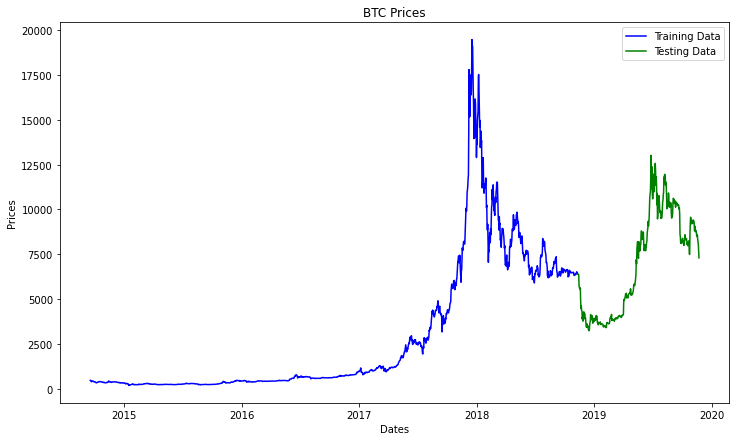

In [15]:
plt.figure(figsize=(12,7))
plt.title('BTC Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_data['Open'], 'blue', label='Training Data')
plt.plot(test_data['Open'], 'green', label='Testing Data')
plt.legend();

### Auto ARIMAX model

In [10]:
!pip install pmdarima
import pmdarima as pmd
#names.append("Auto ARIMA")
exogenous_features=['lag_num_tweets','lag_tb_subjectivity','lag_tb_polarity','lag_vd_sentiment']
autoarima_model = pmd.auto_arima(train_data['Open'],start_p=0, max_p=5,start_q=0,max_q=5,test="adf",
                              exogenous=train_data[exogenous_features],trace=True)


autoarima_model.fit(train_data.Open, exogenous=train_data[exogenous_features])


autoarima_model.summary()


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=21250.281, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=21243.250, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=21242.618, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=21248.606, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=21231.694, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=21244.572, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=21244.970, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=21242.937, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=21243.186, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=21235.652, Time=0.43 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=21229.949, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=21240.894, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=21241.527, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=21242.779, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1515
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -10611.975
Date:                Fri, 11 Nov 2022   AIC                          21229.949
Time:                        00:51:09   BIC                          21245.917
Sample:                    09-17-2014   HQIC                         21235.895
                         - 11-09-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7247      0.031    -23.167      0.000      -0.786      -0.663
ma.L1          0.8093      0.028     29.056      0.000       0.755       0.864
sigma2      7.172e+04    658.115    108.980      0.000    7.04e+04     7.3e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):             84985.41
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):            1744.87   Skew:                             1.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        39.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Now use the auto arima model we found to predict the resul 

In [11]:
test_series = test_data['Open']
train_series = train_data['Open']

history = [x for x in train_series]
history_exo=[x for x in train_data[exogenous_features]]

auto_arima_predictions = list()
for t in range(len(test_series)):

    #call the ARIMA Method with history and params
    #model = ARIMA(history,order=(10,1,0))  # initialize the model with history and right order of parameters
    model_fit = autoarima_model.fit(history)#,exogenous=history_exo)  # fit the model
  

    output = model_fit.predict(n_periods=1)#,exogenous=train_data[exogenous_features].iloc[t])  # use forecast on the fitted model
    #print(output,t)
    yhat = output[0]
    auto_arima_predictions.append(yhat)

    obs = test_series[t]
    history.append(obs)
    #obs_exo=train_data[exogenous_features][t]
    #history_exo.append(obs_exo)

    if t % 100 == 0:
      print('Test Series Point: {}\tPredicted={}, Expected={}'.format(t, yhat, obs))

Test Series Point: 0	Predicted=6428.585692547266, Expected=6386.129883
Test Series Point: 100	Predicted=3640.949576861324, Expected=3671.369873
Test Series Point: 200	Predicted=8801.5286066003, Expected=8718.591797
Test Series Point: 300	Predicted=10592.574575777462, Expected=10578.198242


In [20]:
error = mean_squared_error(test_series, auto_arima_predictions)
print('Auto ARIMA Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_series, auto_arima_predictions)
print('Auto ARIMA Symmetric Mean absolute percentage error: %.3f' % error2)



auto_arima_predictions_series = pd.Series(auto_arima_predictions)
auto_arima_predictions_series.index = test_series.index

Auto ARIMA Testing Mean Squared Error: 102050.342
Auto ARIMA Symmetric Mean absolute percentage error: 2.644


# Time Series Forecasting with Deep Learning

Here we use LSTM for time series prediction.

In [14]:
# Let's load the libraries and dependencies for the deep learning model
from sklearn.preprocessing import MinMaxScaler

#%tensorflow_version 1.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD

## Build Train-Test Datasets

In [15]:
# Splitting the train and test set considering 'Open' feature from the dataset
#train_data, test_data = btc_price.iloc[0:int(len(btc_price)*0.8), :], btc_price.iloc[int(len(btc_price)*0.8):, :]
train_series = train_data['Open']
test_series = test_data['Open']
train_num_tweets_series = train_data['lag_num_tweets']
test_num_tweets_series = test_data['lag_num_tweets']

train_vd_sent_series = train_data['lag_vd_sentiment']
test_vd_sent_series = test_data['lag_vd_sentiment']

#train_fl_sent_series = train_data['lag_fl_sentiment']
#test_fl_sent_series = test_data['lag_fl_sentiment']


train_tb_sent_series = train_data['lag_tb_polarity']
test_tb_sent_series = test_data['lag_tb_polarity']

train_tb_subj_series = train_data['lag_tb_subjectivity']
test_tb_subj_series = test_data['lag_tb_subjectivity']

train_series.shape, test_series.shape

((1515,), (379,))

### Scaling
As stock prices can vary across a wide range, we scale the data to have zero mean and unit variance. This is done to ensure that the gradient descent is sooner when learning a deep learning model

In [16]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(train_data[['Open']])

### Train Data Preparation

Train data uses the previous 60 days (two months) data to predict the stock price of the next day.
The data is prepared just like a sliding window approach, where
*window_size = 60*


In [17]:
#1 output and 60 values inputs
# So for each element of training set (output), we have 60 previous training set elements (input)
X_train = []
y_train = []
print(type(training_set_scaled[89-60:89,0]))
for i in range(60, len(training_set_scaled)):
    temp=np.append(training_set_scaled[i-60:i,0],train_vd_sent_series[i])
    temp=np.append(temp,train_tb_sent_series[i])
    temp=np.append(temp,train_tb_subj_series[i])
    #temp=np.append(temp,train_fl_sent_series[i])
    temp=np.append(temp,train_num_tweets_series[i])
    X_train.append(temp)#;train_hf_sent_series[i]])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

<class 'numpy.ndarray'>


((1455, 64), (1455,))

#### Reshape X_train



In [18]:
# Reshaping X_train for efficient modeling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1], 1))
X_train.shape

(1455, 64, 1)

### LSTM Regression model

We use  [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM):
*   units - output dimensions
*   return_sequences is set to True to get all the hidden state vectors information

The model uses 2 LSTM layers followed by a Dense Layer with a single neuron to output regression prediction.

### Building the LSTM based forecasting DL Model architecture


In [19]:

regressor = Sequential()

# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
'''
# Second LSTM layer
regressor.add(LSTM(units=64, return_sequences=True,input_shape=(64,1)))
regressor.add(Dropout(0.2))

'''
# Second LSTM layer
regressor.add(LSTM(units=64, return_sequences=False,input_shape=(64,1)))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN - optimizer(rmsprop)and loss(mean squared error)

regressor.compile(optimizer='rmsprop',loss='mse')
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64, 64)            16896     
                                                                 
 dropout (Dropout)           (None, 64, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [29]:
regressor.fit(X_train,y_train, epochs=15, batch_size=64, validation_split=0.1, shuffle=True)

Epoch 1/15
21/21 [==============================] - 0s 13ms/step - loss: 0.0018 - val_loss: 6.9367e-04
Epoch 2/15
21/21 [==============================] - 0s 12ms/step - loss: 0.0016 - val_loss: 0.0025
Epoch 3/15
21/21 [==============================] - 0s 11ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 4/15
21/21 [==============================] - 0s 10ms/step - loss: 0.0016 - val_loss: 0.0058
Epoch 5/15
21/21 [==============================] - 0s 12ms/step - loss: 0.0015 - val_loss: 4.5233e-04
Epoch 6/15
21/21 [==============================] - 0s 12ms/step - loss: 0.0014 - val_loss: 0.0161
Epoch 7/15
21/21 [==============================] - 0s 9ms/step - loss: 0.0018 - val_loss: 0.0111
Epoch 8/15
21/21 [==============================] - 0s 10ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 9/15
21/21 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 6.0621e-04
Epoch 10/15
21/21 [==============================] - 0s 11ms/step - loss: 0.0013 - val_loss: 3.344

### Test Data Forecasting



In [30]:
train_last60 = train_series[-60:]
print(train_last60.shape)
test_series.shape

(60,)


(379,)

### Combine both train_last60 and test_series together 



In [31]:
new_test_series =  pd.concat([train_last60,test_series],axis=0)
print(new_test_series.shape)


(439,)


In [32]:
test_set_scaled = sc.fit_transform(new_test_series.values.reshape(-1,1))

### Prepare Test dataset Windows of 60  days each

In [33]:
# Preparing X_test and predicting the prices
X_test = []
print(test_vd_sent_series.shape)
print(test_set_scaled.shape)
for i in range(60,len(test_set_scaled)):

    temp=np.append(test_set_scaled[i-60:i,0],train_vd_sent_series[i])
    temp=np.append(temp,train_tb_sent_series[i])
    temp=np.append(temp,train_tb_subj_series[i])
    #temp=np.append(temp,train_fl_sent_series[i])
    temp=np.append(temp,train_num_tweets_series[i])
    X_test.append(temp)

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
X_test.shape

(379,)
(439, 1)


(379, 64, 1)

### Model Prediction and Reverse Transform of Prices

In [34]:
predicted_stock_price = regressor.predict(X_test)
print(X_test.shape)
print(predicted_stock_price.shape)
predicted_stock_price_revtrans = sc.inverse_transform(predicted_stock_price).ravel()
predicted_stock_price_revtrans_series = pd.Series(predicted_stock_price_revtrans)
predicted_stock_price_revtrans_series.index = test_series.index
predicted_stock_price_revtrans_series.shape, test_series.shape

12/12 [==============================] - 0s 3ms/step
(379, 64, 1)
(379, 1)


((379,), (379,))

## Model Evaluation

In [35]:
# Evaluating our model
error = mean_squared_error(test_series, predicted_stock_price_revtrans_series)
print('Testing Mean Squared Error: %.3f' % error)
#MSE.append(error)
error2 = smape_kun(test_series, predicted_stock_price_revtrans_series)
print('Symmetric Mean absolute percentage error: %.3f' % error2)
#SMAPE.append(error2)

Testing Mean Squared Error: 530388.179
Symmetric Mean absolute percentage error: 6.798


## Visualizing the results from model predictions

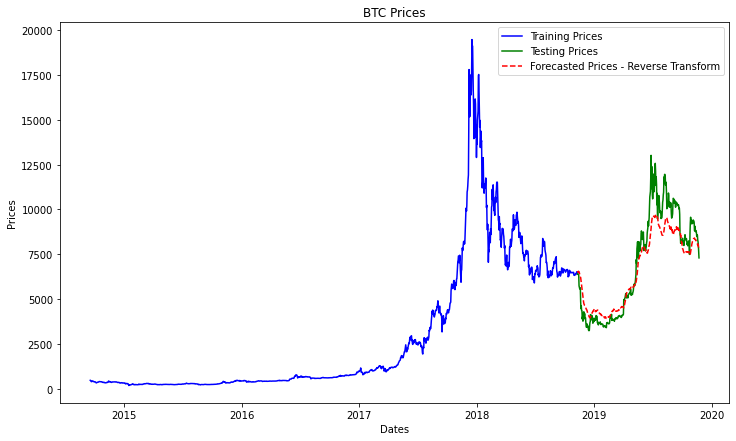

In [35]:
plt.figure(figsize=(12,7))
plt.title('BTC Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_series, color='blue', label='Training Prices')
plt.plot(test_series, color='green', label='Testing Prices')
plt.plot(predicted_stock_price_revtrans_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Transform')
plt.legend();

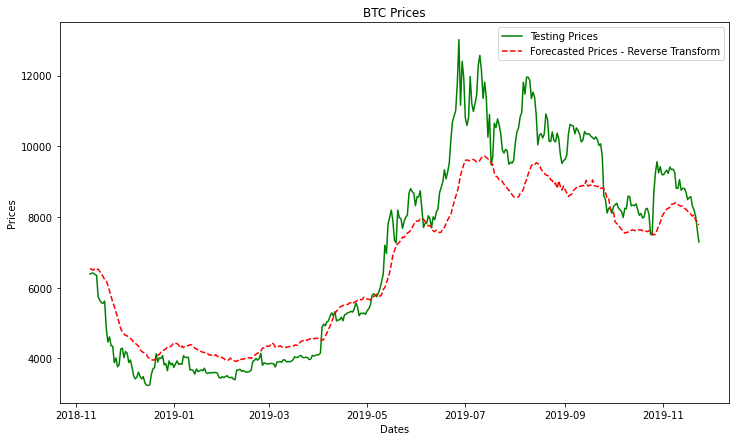

In [36]:
plt.figure(figsize=(12,7))
plt.title('BTC Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(test_series, color='green', label='Testing Prices')
plt.plot(predicted_stock_price_revtrans_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Transform')
plt.legend();